In [1]:
import pandas as pd
import json
import geopandas as gpd
import shapely
from matplotlib import pyplot as plt
from cartopy import crs as ccrs

c:\Users\soalv\miniconda3\envs\SLearn\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\soalv\miniconda3\envs\SLearn\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\soalv\miniconda3\envs\SLearn\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
centroids = gpd.read_file('centroids.geojson')

In [3]:
traslados_day0 = pd.read_csv('Day0_Full_Filtered.csv')

In [4]:
centromty_polygon = shapely.Polygon([
    (-100.351,25.705),
    (-100.353,25.671),
    (-100.307,25.662),
    (-100.278,25.673),
    (-100.268,25.683),
    (-100.268,25.703)
])

# create geodataframe
centromty_gdf = gpd.GeoDataFrame(geometry=[centromty_polygon])
centromty_gdp = gpd.GeoSeries([centromty_polygon]).__geo_interface__

In [5]:
# Extract the H3 index of the centroid
traslados_day0_keyonly = traslados_day0[['h3_origin','h3_destination','hour_origin','dsemana_origin','count']]

In [6]:
# Convert centroids geodataframe to dataframe
centroids_df = pd.DataFrame(centroids)

reemplazo_traslados = traslados_day0_keyonly.copy()

# Replace the h3_origin column in data_traslados_zmm with the corresponding geometry from centroids
reemplazo_traslados['h3_origin'] = reemplazo_traslados['h3_origin'].map(centroids_df.set_index('h3_polyfill')['geometry'])

# Replace the h3_destination column in data_traslados_zmm with the corresponding geometry from centroids
reemplazo_traslados['h3_destination'] = reemplazo_traslados['h3_destination'].map(centroids_df.set_index('h3_polyfill')['geometry'])

# Display the data
reemplazo_traslados.head()

,h3_origin,h3_destination,hour_origin,dsemana_origin,count
0,POINT (-100.27967 25.68893),POINT (-100.28269 25.69097),7,0,1
1,POINT (-100.27967 25.68893),POINT (-100.28269 25.69097),10,0,2
2,POINT (-100.27967 25.68893),POINT (-100.28269 25.69097),19,0,2
3,POINT (-100.27967 25.68893),POINT (-100.28269 25.69097),20,0,1
4,POINT (-100.27967 25.68893),POINT (-100.27622 25.69028),2,0,1


In [7]:
reemplazo_traslados.to_csv('Day0_Full_Filtered_Centroids.csv', index=False)

In [8]:
# Create line strings from the origin and destination points
reemplazo_traslados['h3_line'] = reemplazo_traslados.apply(lambda x: shapely.geometry.LineString([x['h3_origin'], x['h3_destination']]), axis=1)

In [9]:
# Divide data into 3 dataframes: one for origin, one for destination and one for the lines
origen = reemplazo_traslados[['h3_origin','hour_origin','dsemana_origin','count']].copy()
origen['geometry'] = origen['h3_origin']
origen.drop(columns=['h3_origin'], inplace=True)
origen = gpd.GeoDataFrame(origen)

destino = reemplazo_traslados[['h3_destination','hour_origin','dsemana_origin','count']].copy()
destino['geometry'] = destino['h3_destination']
destino.drop(columns=['h3_destination'], inplace=True)
destino = gpd.GeoDataFrame(destino)

lineas = reemplazo_traslados[['h3_line','hour_origin','dsemana_origin','count']].copy()
lineas['geometry'] = lineas['h3_line']
lineas.drop(columns=['h3_line'], inplace=True)
lineas = gpd.GeoDataFrame(lineas)

In [10]:
# Expprt to geojson
origen.to_file('Day0_FiltCent_origin.geojson', driver='GeoJSON')
destino.to_file('Day0_FiltCent_destination.geojson', driver='GeoJSON')

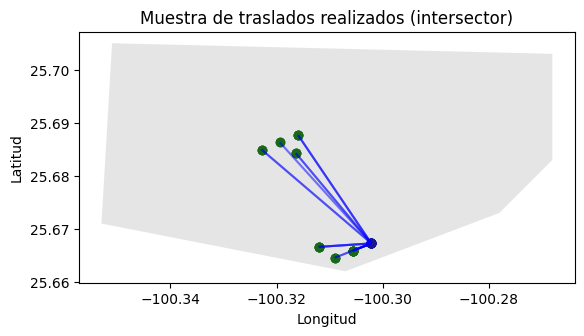

In [11]:
# Create a geodataframe from the data
reemplazo_traslados_gdf = gpd.GeoDataFrame(reemplazo_traslados, geometry='h3_origin')

# Plot the data
fig, ax = plt.subplots()
lineas.tail(30).plot(ax=ax, color='blue', alpha=0.3)
origen.tail(30).plot(ax=ax, color='darkblue')
destino.tail(30).plot(ax=ax, color='darkgreen')
centromty_gdf.plot(ax=ax, color='grey', alpha=0.2)
plt.title('Muestra de traslados realizados (intersector)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

In [12]:
# Load transport data
transporte = gpd.read_file('data_transporte_inside.geojson')


# Load working area sectors
workingarea = gpd.read_file('workingarea.geojson')

In [13]:
transporte.columns

Index(['id', 'fid', 'tipo', 'ancho_de_via_m', 'nombre', 'nota',
       'observaciones', 'longitud_m', 'geometry'],
      dtype='object')

In [14]:
# For each element in worknnig area, check which elements of the transport data are inside
transport_by_area = workingarea.copy()

for i in range(0,len(transport_by_area)):
    transport_by_area.loc[i,'transporte_inside'] = transporte.within(transport_by_area.loc[i,'geometry']).sum()

In [15]:
transport_by_area_df = pd.DataFrame(transport_by_area)

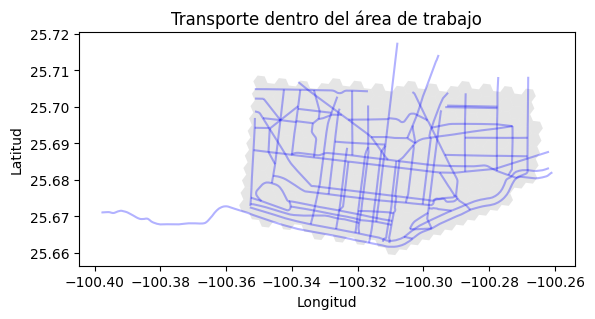

In [16]:
# Plot working area and transport data
fig, ax = plt.subplots()
transporte.plot(ax=ax, color='blue', alpha=0.3)
workingarea.plot(ax=ax, color='grey', alpha=0.2)
plt.title('Transporte dentro del área de trabajo')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

In [17]:
sectors_workingarea_list = workingarea['h3_polyfill'].tolist()
intersections_bysector_df = pd.DataFrame(columns=['vialidad']+sectors_workingarea_list)

In [18]:
for road,iter in transporte.iterrows():
    # Get road geometry
    road_geom = iter.geometry
    # Get road name
    road_name = iter['nombre']
    
    # Get intersections between road and working area sectors
    intersections = workingarea[workingarea.intersects(road_geom)]
    # Get list of sectors that intersect with the road
    intersections_list = intersections['h3_polyfill'].tolist()
    # Create a binary list of sectors that intersect with the road
    intersections_bin = [1 if sector in intersections_list else 0 for sector in sectors_workingarea_list]

    # Store obtained data in a row
    row = [road_name]+intersections_bin
    # Append row to the dataframe
    intersections_bysector_df.loc[len(intersections_bysector_df)] = row

In [19]:
# Join rows with same road name
intersections_bysector_df = intersections_bysector_df.groupby('vialidad').sum().reset_index()

intersections_bysector_df.to_csv('intersections_bysector.csv', index=False)

C:\Users\soalv\AppData\Local\Temp\ipykernel_6892\1843343254.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  unique_colors = plt.cm.get_cmap('tab10', len(intersections_bysector_df))


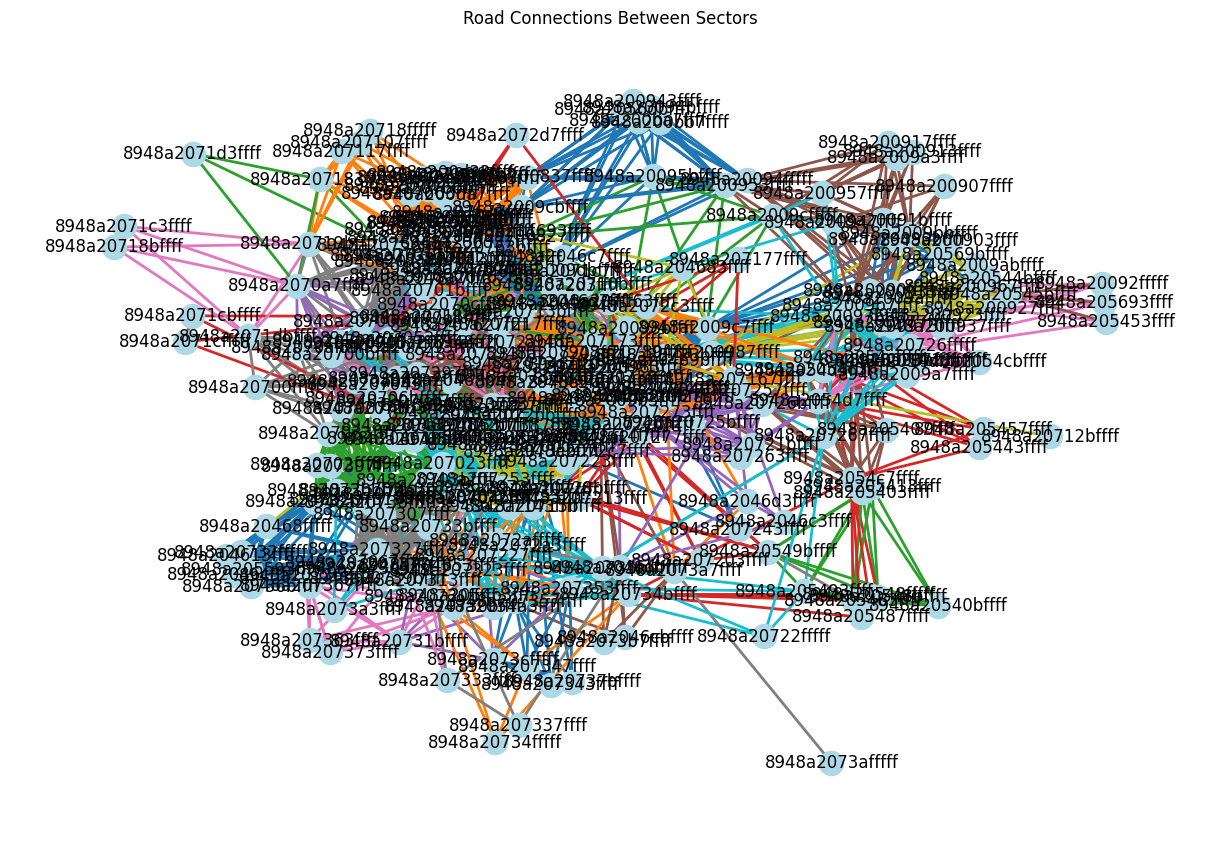

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import random

# Initialize the graph
G = nx.Graph()

# Create a color map
unique_colors = plt.cm.get_cmap('tab10', len(intersections_bysector_df))

# Iterate over each row in intersections_bysector_df to add edges
for idx, row in intersections_bysector_df.iterrows():
    road_name = row['vialidad']
    
    # Get sectors connected by this road (where intersection is 1)
    sectors_connected = [sector for sector, intersect in zip(sectors_workingarea_list, row[1:]) if intersect == 1]
    
    # Add edges between each pair of connected sectors for this road
    color = unique_colors(idx)  # Unique color for this road
    for sector1, sector2 in itertools.combinations(sectors_connected, 2):
        # Add edge with a color attribute for visualization
        G.add_edge(sector1, sector2, color=color, label=road_name)

# Plot the graph
pos = nx.spring_layout(G)  # Layout for better visualization
edges = G.edges(data=True)
edge_colors = [edge[2]['color'] for edge in edges]  # Extract edge colors

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color=edge_colors, width=2, edge_cmap=unique_colors)
plt.title("Road Connections Between Sectors")
plt.show()


In [21]:
from pyvis.network import Network
import networkx as nx
import itertools

# Initialize the Networkx graph and Pyvis Network
G = nx.Graph()
net = Network(notebook=True, width="1000px", height="800px")

# Iterate over each row in intersections_bysector_df to add edges
for idx, row in intersections_bysector_df.iterrows():
    road_name = row['vialidad']
    
    # Get sectors connected by this road (where intersection is 1)
    sectors_connected = [sector for sector, intersect in zip(sectors_workingarea_list, row[1:]) if intersect == 1]
    
    # Assign a unique color to each road
    color = f'#{random.randint(0, 0xFFFFFF):06x}'  # Generate a random hex color for each road
    
    # Add nodes and edges to the network
    for sector in sectors_connected:
        net.add_node(sector, label=sector)
    
    for sector1, sector2 in itertools.combinations(sectors_connected, 2):
        net.add_edge(sector1, sector2, color=color, title=road_name)

# Set options for better visualization
net.set_options("""
var options = {
  "nodes": {
    "shape": "dot",
    "size": 10
  },
  "edges": {
    "color": {
      "inherit": false
    },
    "smooth": false
  },
  "physics": {
    "enabled": true
  }
}
""")

# Save as HTML file
net.show("road_connections.html")

road_connections.html


In [22]:
import random

test_traslados = traslados_day0_keyonly.sample(10)

In [25]:
# Step 1: Build the graph with road connections from intersections_bysector_df
G = nx.Graph()

# Iterate over each row in intersections_bysector_df to add edges to the graph
for idx, row in intersections_bysector_df.iterrows():
    road_name = row['vialidad']
    
    # Get sectors connected by this road (where intersection is 1)
    sectors_connected = [sector for sector, intersect in zip(sectors_workingarea_list, row[1:]) if intersect == 1]
    
    # Add edges between each pair of connected sectors for this road
    for sector1, sector2 in itertools.combinations(sectors_connected, 2):
        G.add_edge(sector1, sector2, road=road_name)

# Step 2: Define a function to find a route and track road changes
def find_route(G, start_node, end_node):
    if start_node not in G.nodes or end_node not in G.nodes:
        return "Start or end node not found in the graph."
    try:
        # Find shortest path based on nodes
        path = nx.shortest_path(G, source=start_node, target=end_node)
        
        # Track the road names used along the path
        route = []
        current_road = G.edges[path[0], path[1]]['road']
        segment = [path[0]]  # Initialize with the start node
        
        for i in range(1, len(path)):
            edge_road = G.edges[path[i-1], path[i]]['road']
            if edge_road != current_road:
                # Add the completed segment to the route
                segment.append(path[i-1])
                route.append((current_road, segment))
                
                # Start a new segment on a different road
                current_road = edge_road
                segment = [path[i-1]]
                
            segment.append(path[i])
        
        # Add the final segment to the route
        route.append((current_road, segment))
        
        return route
    
    except nx.NetworkXNoPath:
        return f"No route found from {start_node} to {end_node}."

# Step 3: Loop over test_traslados and calculate routes
for idx, traslado in test_traslados.iterrows():
    origin_sector = traslado['h3_origin']
    destination_sector = traslado['h3_destination']
    
    # Find the route between origin and destination
    route = find_route(G, origin_sector, destination_sector)
    
    # Display the route for each traslado
    print(f"Route from {origin_sector} to {destination_sector}:")
    if isinstance(route, str):  # If no route found, route is a string
        print(route)
    else:
        for road, segment in route:
            print(f"{road}: {' - '.join(segment)}")
    print("\n")


Route from 8948a207033ffff to 8948a207003ffff:
Mariano Matamoros: 8948a207033ffff - 8948a20705bffff - 8948a20705bffff
Fray Servando Padre Mier: 8948a20705bffff - 8948a207003ffff


Route from 8948a200907ffff to 8948a20090fffff:
Ingeniero Francisco Beltrán: 8948a200907ffff - 8948a20090fffff


Route from 8948a207037ffff to 8948a207003ffff:
Washington: 8948a207037ffff - 8948a207073ffff - 8948a207073ffff
Serafín Peña: 8948a207073ffff - 8948a207003ffff


Route from 8948a20738fffff to 8948a2073a3ffff:
Av. Venustiano Carranza: 8948a20738fffff - 8948a2073bbffff - 8948a2073bbffff
Thomas Alva Edison: 8948a2073bbffff - 8948a2073a3ffff


Route from 8948a207043ffff to 8948a20705bffff:
Mariano Matamoros: 8948a207043ffff - 8948a20705bffff


Route from 8948a20720fffff to 8948a2072d7ffff:
Av. Francisco I. Madero: 8948a20720fffff - 8948a207247ffff - 8948a207247ffff
Av. Félix Uresti Gómez: 8948a207247ffff - 8948a2072c3ffff - 8948a2072c3ffff
Florencio Antillón: 8948a2072c3ffff - 8948a2072d7ffff


Route fro

In [26]:
# Export network to GEXF format
nx.write_gexf(G, "red-vialidades.gexf")